# Save and Load Models

Saving and loading trained Deep Learning models has multiple valuable uses. These models are often costly to train; storing a pre-trained model can help reduce costs as it can be loaded and reused to forecast multiple times. Moreover, it enables Transfer learning capabilities, consisting of pre-training a flexible model on a large dataset and using it later on other data with little to no training. It is one of the most outstanding 🚀 achievements in Machine Learning 🧠 and has many practical applications.

In this notebook we show an example on how to save and load `NeuralForecast` models.

The two methods to consider are:<br>
1. `NeuralForecast.save`: Saves models into disk, allows save dataset and config.<br>
2. `NeuralForecast.load`: Loads models from a given path.<br>

:::{.callout-important}
This Guide assumes basic knowledge on the NeuralForecast library. For a minimal example visit the [Getting Started](./Getting_Started.ipynb) guide.
:::

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Save_Load_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

## 2. Loading AirPassengers Data

For this example we will use the classical [AirPassenger Data set](https://www.kaggle.com/datasets/rakannimer/air-passengers). Import the pre-processed AirPassenger from `utils`.

In [ ]:
from neuralforecast.utils import AirPassengersDF

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop=True)
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## 3. Model Training

Next, we instantiate and train three models: `NBEATS`, `NHITS`, and `AutoMLP`. The models with their hyperparameters are defined in the `models` list.

In [ ]:
from ray import tune

from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoMLP
from neuralforecast.models import NBEATS, NHITS

In [ ]:
%%capture
horizon = 12
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=50),
          AutoMLP(# Ray tune explore config
                  config=dict(max_steps=100, # Operates with steps not epochs
                              input_size=tune.choice([3*horizon]),
                              learning_rate=tune.choice([1e-3])),
                  h=horizon,
                  num_samples=1, cpus=1)]

In [ ]:
%%capture
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)

Produce the forecasts with the `predict` method.

In [ ]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.79it/s]


,unique_id,ds,NBEATS,NHITS,AutoMLP
0,1.0,1961-01-31,428.410553,445.268158,452.550446
1,1.0,1961-02-28,425.958557,469.293945,442.683807
2,1.0,1961-03-31,477.748016,462.920807,474.043457
3,1.0,1961-04-30,477.548798,489.986633,503.836334
4,1.0,1961-05-31,495.973541,518.612610,531.347900


We plot the forecasts for each model. Note how the two `NBEATS` models are differentiated with a numerical suffix.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

<matplotlib.legend.Legend>

<Figure size 1200x300 with 0 Axes>

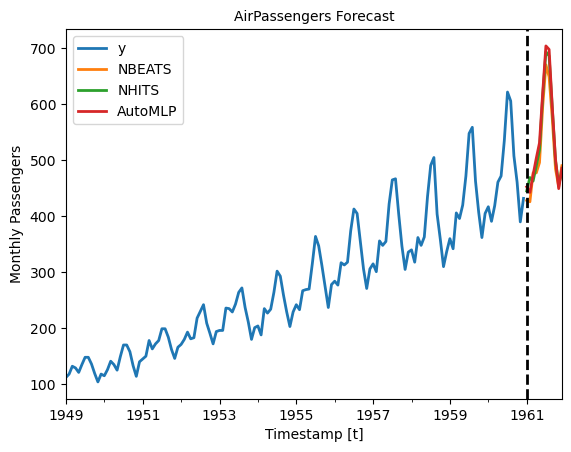

In [ ]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'AutoMLP']].plot(linewidth=2)

plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x=plot_df.index[-horizon], color='k', linestyle='--', linewidth=2)
plt.legend(prop={'size': 10})

## 4. Save models

To save all the trained models use the `save` method. This method will save both the hyperparameters and the learnable weights (parameters).

The `save` method has the following inputs:

* `path`: directory where models will be saved.
* `model_index`: optional list to specify which models to save. For example, to only save the `NHITS` model use `model_index=[2]`.
* `overwrite`: boolean to overwrite existing files in `path`. When True, the method will only overwrite models with conflicting names.
* `save_dataset`: boolean to save `Dataset` object with the dataset.

In [ ]:
nf.save(path='./checkpoints/test_run/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

For each model, two files are created and stored:

* `[model_name]_[suffix].ckpt`: Pytorch Lightning checkpoint file with the model parameters and hyperparameters.
* `[model_name]_[suffix].pkl`: Dictionary with configuration attributes.

Where `model_name` corresponds to the name of the model in lowercase (eg. `nhits`). We use a numerical suffix to distinguish multiple models of each class. In this example the names will be `automlp_0`, `nbeats_0`, and `nhits_0`.

:::{.callout-important}
The `Auto` models will be stored as their base model. For example, the `AutoMLP` trained above is stored as an `MLP` model, with the best hyparparameters found during tuning.
:::

## 5. Load models

Load the saved models with the `load` method, specifying the `path`, and use the new `nf2` object to produce forecasts.

In [ ]:
nf2 = NeuralForecast.load(path='./checkpoints/test_run/')
Y_hat_df = nf2.predict().reset_index()
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.82it/s]


,unique_id,ds,MLP,NHITS,NBEATS
0,1.0,1961-01-31,452.550446,445.268158,428.410553
1,1.0,1961-02-28,442.683807,469.293945,425.958557
2,1.0,1961-03-31,474.043457,462.920807,477.748016
3,1.0,1961-04-30,503.836334,489.986633,477.548798
4,1.0,1961-05-31,531.347900,518.612610,495.973541


Finally, plot the forecasts to confirm they are identical to the original forecasts.

<Figure size 1200x300 with 0 Axes>

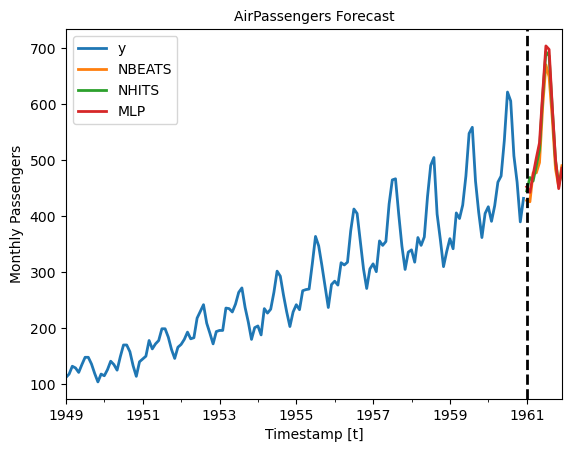

In [ ]:
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes

plt.figure(figsize = (12, 3))
plot_df[['y', 'NBEATS', 'NHITS', 'MLP']].plot(linewidth=2)

plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.axvline(x=plot_df.index[-horizon], color='k', linestyle='--', linewidth=2)
plt.legend(prop={'size': 10})
plt.show()

## References

https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html

[Oreshkin, B. N., Carpov, D., Chapados, N., & Bengio, Y. (2019). N-BEATS: Neural basis expansion analysis for interpretable time series forecasting. ICLR 2020](https://arxiv.org/abs/1905.10437)

[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)